# Import libraries and modules

In [1]:
# Reload modules before executing user code
%load_ext autoreload
%autoreload 2

import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from scipy.io import loadmat

# Find current directory
current_dir = os.getcwd()
# Find root directory
root_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
# Add root directory to path
sys.path.append(root_dir)

print(f"Current directory: {current_dir}")
print(f"Root directory: {root_dir}")

import pysindy.pysindy as ps
from pysindy.differentiation import SmoothedFiniteDifference

# ignore user warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

np.random.seed(1000)  # Seed for reproducibility

# Integrator keywords for solve_ivp
integrator_keywords = {}
integrator_keywords['method'] = 'RK23'   #'LSODA'
integrator_keywords['rtol'] = 1.0  # 1e-3
integrator_keywords['atol'] = 1.0  # 1e-4
integrator_keywords['max_step'] = 0.1
integrator_keywords['h_factor'] = 1

system_size = 50
n_samples_train = 2000
n_samples_test = 5000

poly_order = 2
threshold = 0
dt = 1

Current directory: /u1/ame805/pysindy_fork/simlab_experiments
Root directory: /u1/ame805/pysindy_fork


# Functions

In [2]:
def readExpData(file_path, Nsize=100):
    
    if os.path.isfile(file_path):
        
        # extract data from file using numpy module
        data = np.loadtxt(file_path)
        size = np.shape(data)

        t_data = np.empty(shape=(size[0],))
        # first column of the file is time
        t_data[:] = data[:, 0]

        # remaining data is number of clusters of size n. Index for column i corresponds to number of clusters of size i-1
        # n_data = data[:, 1:Nsize+1]
        #** We just divide the cluster numbers by the volume of the system which is 126^3 (in units of sigma). 
        n_data = data[:, 1:Nsize+1] / (126**3)  ## only the first 'size' (excluding the very first 0) entries to match the kappa coeff
        
        return t_data, n_data
    
    else:
        print(f"Experiment file ({file_path}) does not exist")
        exit()

# Load data

In [3]:
experiment_dir = 'data'
experiment_file = 'Population_Training_Results.dat'
exp_dir = os.path.join(experiment_dir, experiment_file)

t_values, N_clusters = readExpData(exp_dir, Nsize=system_size)

# # n_samples_train random indices
# indices = np.random.choice(len(t_values), n_samples_train, replace=False)
# indices = np.sort(indices)
# Linearly spaced indices
indices = np.linspace(0, len(t_values)-1, n_samples_train, dtype=int)
N_clusters_train = N_clusters[indices]
t_values_train = t_values[indices]

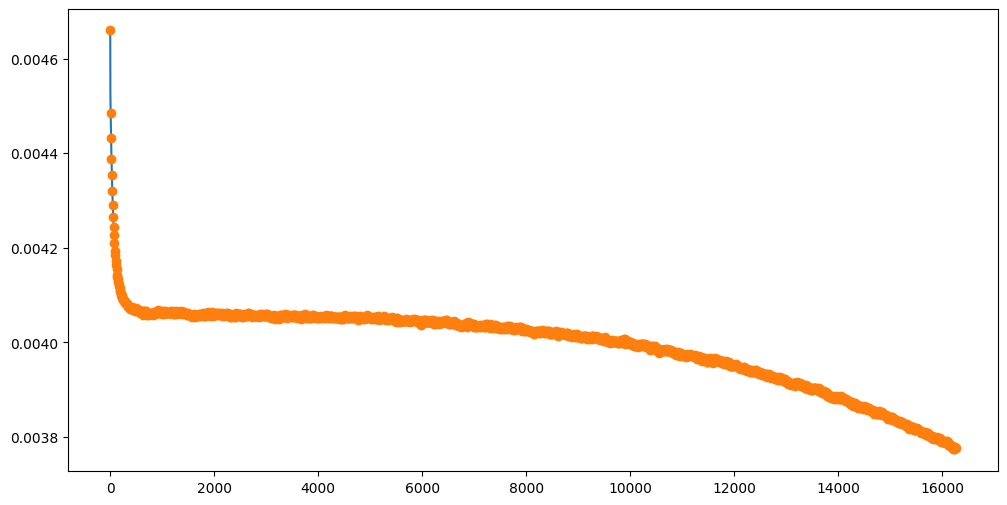

In [4]:
n_to_plot = 1

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(t_values, N_clusters[:, n_to_plot-1], label=f'Cluster size {n_to_plot}')
# plt.plot(t_values[:n_samples_train], N_clusters[:n_samples_train, n_to_plot-1], label=f'Cluster size {n_to_plot}')
plt.plot(t_values_train, N_clusters_train[:, n_to_plot-1], 'o', label=f'Training data Cluster size {n_to_plot}')

plt.show()

# Prepare the model (add constraints)

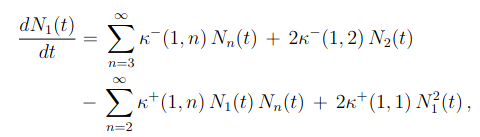

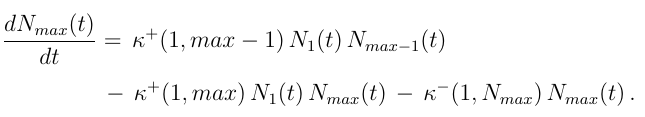

In [5]:
# Figure out how many library features there will be
library = ps.PolynomialLibrary()
library.fit([ps.AxesArray(N_clusters_train, {"ax_sample": 0, "ax_coord": 1})])
features_names = library.get_feature_names()
n_features = library.n_output_features_
print(f"Features ({n_features}):", features_names)

Features (1326): ['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49', 'x0^2', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x0 x5', 'x0 x6', 'x0 x7', 'x0 x8', 'x0 x9', 'x0 x10', 'x0 x11', 'x0 x12', 'x0 x13', 'x0 x14', 'x0 x15', 'x0 x16', 'x0 x17', 'x0 x18', 'x0 x19', 'x0 x20', 'x0 x21', 'x0 x22', 'x0 x23', 'x0 x24', 'x0 x25', 'x0 x26', 'x0 x27', 'x0 x28', 'x0 x29', 'x0 x30', 'x0 x31', 'x0 x32', 'x0 x33', 'x0 x34', 'x0 x35', 'x0 x36', 'x0 x37', 'x0 x38', 'x0 x39', 'x0 x40', 'x0 x41', 'x0 x42', 'x0 x43', 'x0 x44', 'x0 x45', 'x0 x46', 'x0 x47', 'x0 x48', 'x0 x49', 'x1^2', 'x1 x2', 'x1 x3', 'x1 x4', 'x1 x5', 'x1 x6', 'x1 x7', 'x1 x8', 'x1 x9', 'x1 x10', 'x1 x11', 'x1 x12', 'x1 x13', 'x1 x14', 'x1 x15', 'x1 x16'

## Tests

In [6]:
# Set constraints
n_targets = N_clusters_train.shape[1]

constraint_rhs = np.array([0, 28])# One row per constraint, one column per coefficient

# One row per constraint, one column per coefficient
constraint_lhs = np.zeros((2, n_targets * n_features))

# 1 * (x0 coefficient) + 1 * (x1 coefficient) = 0
constraint_lhs[0, 1] = 1
constraint_lhs[0, 2] = 1

# 1 * (x0 coefficient) = 28
constraint_lhs[1, 1 + n_features] = 1

print(f"constraint_rhs.shape: {constraint_rhs.shape}")
print(f"constraint_lhs.shape: {constraint_lhs.shape}")


constraint_rhs.shape: (2,)
constraint_lhs.shape: (2, 66300)


## Set up and 1st eq

In [7]:
#### Set constraints
# Number of clusters/equations
n_targets = N_clusters_train.shape[1]

print(f"Features ({n_features}):", features_names)

# Find the indices of quadratic terms in the features_names list
# quadratic_idx_pure = [i for i, feature_name in enumerate(features_names) if '^2' in feature_name and 'x0^2' not in feature_name]
quadratic_idx_first = [i for i, feature_name in enumerate(features_names) if ('^2' in feature_name or feature_name.count('x') == 2) and 'x0' not in feature_name]
n_quadratic_first = len(quadratic_idx_first)

# Initialize constraint_rhs
constraint_rhs = np.zeros(n_quadratic_first)

# Initialize constraint_lhs
constraint_lhs = np.zeros((n_quadratic_first, n_targets * n_features))

# Set the coefficient of each quadratic term (excluding 'x0^2') to zero
for i, idx in enumerate(quadratic_idx_first):
    # Exclude 'x0^2'
    if 'x0^2' != features_names[idx]:
        constraint_lhs[i, idx] = 1

# print(100*'*')
# print(f"quadratic_idx_pure (excluding 'x0^2'): {quadratic_idx_first}")
# print(f"constraint_rhs.shape: {constraint_rhs.shape}")
# print(f"constraint_lhs.shape: {constraint_lhs.shape}")
# print(100*'*')

## 2- Coeff of x0 is zero
constraint_rhs = np.append(constraint_rhs, 0)
constraint_lhs = np.vstack((constraint_lhs, np.zeros((1, n_targets * n_features))))
# Get the index of x0
x0_idx = features_names.index('x0')
constraint_lhs[-1, x0_idx] = 1

last_row = n_quadratic_first + 1

Features (1326): ['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49', 'x0^2', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x0 x5', 'x0 x6', 'x0 x7', 'x0 x8', 'x0 x9', 'x0 x10', 'x0 x11', 'x0 x12', 'x0 x13', 'x0 x14', 'x0 x15', 'x0 x16', 'x0 x17', 'x0 x18', 'x0 x19', 'x0 x20', 'x0 x21', 'x0 x22', 'x0 x23', 'x0 x24', 'x0 x25', 'x0 x26', 'x0 x27', 'x0 x28', 'x0 x29', 'x0 x30', 'x0 x31', 'x0 x32', 'x0 x33', 'x0 x34', 'x0 x35', 'x0 x36', 'x0 x37', 'x0 x38', 'x0 x39', 'x0 x40', 'x0 x41', 'x0 x42', 'x0 x43', 'x0 x44', 'x0 x45', 'x0 x46', 'x0 x47', 'x0 x48', 'x0 x49', 'x1^2', 'x1 x2', 'x1 x3', 'x1 x4', 'x1 x5', 'x1 x6', 'x1 x7', 'x1 x8', 'x1 x9', 'x1 x10', 'x1 x11', 'x1 x12', 'x1 x13', 'x1 x14', 'x1 x15', 'x1 x16'

## Eq 2 to N-1

In [8]:

print(f"Features ({n_features}):", features_names)

### Add constraints for the middle cluster sizes (Eq 2 to N-1)
## 1 - All linear terms to be zero except for xN and xN+1
for eq in range(1, n_targets - 1):
    # Find the indices of linear terms in the features_names list
    linear_indices = [i for i, feature_name in enumerate(features_names) if \
                    (feature_name.count('x') == 1 and (f'x{eq}' != feature_name and f'x{eq + 1}' != feature_name)) \
                    and '^' not in feature_name
                ]

    # linear_indices = []
    # for i, feature_name in enumerate(features_names):
    #     # if eq == 1:
    #     #     print(f"feature_name: {i}, {feature_name}")
    #     #     print(feature_name.count('x') == 1, '^' not in feature_name, f'x{eq}' != feature_name, f'x{eq + 1}' != feature_name)
        
    #     # if feature_name.count('x') == 1 and '^' not in feature_name \
    #     #         and f'x{eq}' != feature_name \
    #     #         and f'x{eq + 1}' != feature_name:

    #     # if (feature_name.count('x') == 1  and (f'x{eq}' != feature_name or f'x{eq + 1}' != feature_name)) \
    #     if (feature_name.count('x') == 1 and (f'x{eq}' != feature_name and f'x{eq + 1}' != feature_name)) \
    #             and '^' not in feature_name:
            
    #         linear_indices.append(i)
    #         # if eq == 1:
    #         #     print(feature_name.count('x') == 1, '^' not in feature_name, f'x{eq}' not in feature_name, f'x{eq + 1}' not in feature_name)
    
    
    n_linear = len(linear_indices)

    # Add more columns to constraint_rhs
    constraint_rhs = np.append(constraint_rhs, np.zeros(n_linear))

    # Add more rows to constraint_lhs
    constraint_lhs = np.vstack((constraint_lhs, np.zeros((n_linear, n_targets * n_features))))

    # Set the coefficient of each linear term (excluding 'xN' and 'xN+1') to zero
    for i, idx in enumerate(linear_indices):
        constraint_lhs[i + last_row, eq * n_features + idx] = 1

    # print(100*'*')
    # print(f"Eq {eq+1} - linear_indices (excluding all but x{eq} and x{eq + 1}): {[features_names[idx] for idx in linear_indices]}")
    # print(f"constraint_rhs.shape: {constraint_rhs.shape}")
    # print(f"constraint_lhs.shape: {constraint_lhs.shape}")
    # print(100*'*')

    last_row = last_row + n_linear

    ## 2 - All quadratic terms to be zero except for x0 xN and  x0 xN-1 (this includes x0^2)
    quadratic_idx_mix = [i for i, feature_name in enumerate(features_names) if (feature_name.count('x') == 2 \
                            and f'x0 x{eq}' != feature_name \
                            and f'x0 x{eq - 1}' != feature_name) 
                            or ('^2' in feature_name and 'x0' not in feature_name) \
                            or ('x0^2' in feature_name and eq != 1)
                            ]
    n_quadratic_mix = len(quadratic_idx_mix)

    # Add more columns to constraint_rhs
    constraint_rhs = np.append(constraint_rhs, np.zeros(n_quadratic_mix))

    # Add more rows to constraint_lhs
    constraint_lhs = np.vstack((constraint_lhs, np.zeros((n_quadratic_mix, n_targets * n_features))))

    # Set the coefficient of each quadratic term (excluding 'x0 xN' and 'x0 xN-1') to zero
    for i, idx in enumerate(quadratic_idx_mix):
        # Exclude 'x0 xN' and 'x0 xN-1'
        constraint_lhs[i + last_row, eq * n_features + idx] = 1
    
    # print(100*'*')
    # print(f"Eq {eq+1} - quadratic_idx_mix: {[features_names[idx] for idx in quadratic_idx_mix]}")
    # print(f"constraint_rhs.shape: {constraint_rhs.shape}")
    # print(f"constraint_lhs.shape: {constraint_lhs.shape}")
    # print(100*'*')

    last_row = last_row + n_quadratic_mix


Features (1326): ['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49', 'x0^2', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x0 x5', 'x0 x6', 'x0 x7', 'x0 x8', 'x0 x9', 'x0 x10', 'x0 x11', 'x0 x12', 'x0 x13', 'x0 x14', 'x0 x15', 'x0 x16', 'x0 x17', 'x0 x18', 'x0 x19', 'x0 x20', 'x0 x21', 'x0 x22', 'x0 x23', 'x0 x24', 'x0 x25', 'x0 x26', 'x0 x27', 'x0 x28', 'x0 x29', 'x0 x30', 'x0 x31', 'x0 x32', 'x0 x33', 'x0 x34', 'x0 x35', 'x0 x36', 'x0 x37', 'x0 x38', 'x0 x39', 'x0 x40', 'x0 x41', 'x0 x42', 'x0 x43', 'x0 x44', 'x0 x45', 'x0 x46', 'x0 x47', 'x0 x48', 'x0 x49', 'x1^2', 'x1 x2', 'x1 x3', 'x1 x4', 'x1 x5', 'x1 x6', 'x1 x7', 'x1 x8', 'x1 x9', 'x1 x10', 'x1 x11', 'x1 x12', 'x1 x13', 'x1 x14', 'x1 x15', 'x1 x16'

## Last equation

In [ ]:
print(f"Features ({n_features}):", features_names)

### Add constraints for the last cluster size (Eq N)
## 1 - All linear terms to be zero except for xN
linear_indices = [i for i, feature_name in enumerate(features_names) if feature_name.count('x') == 1 \
                and '^' not in feature_name \
                and f'x{n_targets - 1}' not in feature_name]
n_linear = len(linear_indices)

# Add more columns to constraint_rhs
constraint_rhs = np.append(constraint_rhs, np.zeros(n_linear))

# Add more rows to constraint_lhs
constraint_lhs = np.vstack((constraint_lhs, np.zeros((n_linear, n_targets * n_features))))

# Set the coefficient of each linear term (excluding 'xN') to zero
for i, idx in enumerate(linear_indices):
    constraint_lhs[i + last_row, (n_targets - 1) * n_features + idx] = 1

# print(100*'*')
# print(f"linear_indices (excluding all but x{n_targets-1}): {linear_indices}")
# print(f"constraint_rhs.shape: {constraint_rhs.shape}")
# print(f"constraint_lhs.shape: {constraint_lhs.shape}")
# print(100*'*')

last_row = last_row + n_linear

## 2 - All quadratic terms to be zero except for x0 xN and x0 xN-1
quadratic_idx_last = [i for i, feature_name in enumerate(features_names) if (feature_name.count('x') == 2 \
                     and f'x0 x{n_targets - 1}' not in feature_name \
                     and f'x0 x{n_targets - 2}' not in feature_name) or '^2' in feature_name]
n_quadratic_last = len(quadratic_idx_last)
  
# Add more columns to constraint_rhs
constraint_rhs = np.append(constraint_rhs, np.zeros(n_quadratic_last))

# Add more rows to constraint_lhs
constraint_lhs = np.vstack((constraint_lhs, np.zeros((n_quadratic_last, n_targets * n_features))))

# Set the coefficient of each quadratic term (excluding 'x0 xN' and 'x0 xN-1') to zero
for i, idx in enumerate(quadratic_idx_last):
    # Exclude 'x0 xN' and 'x0 xN-1'
    constraint_lhs[i + last_row, (n_targets - 1) * n_features + idx] = 1

# print(f"quadratic_idx_mix: {quadratic_idx_last}")
# print(f"constraint_rhs.shape: {constraint_rhs.shape}")
# print(f"constraint_lhs.shape: {constraint_lhs.shape}")

Features (231): ['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x0^2', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x0 x5', 'x0 x6', 'x0 x7', 'x0 x8', 'x0 x9', 'x0 x10', 'x0 x11', 'x0 x12', 'x0 x13', 'x0 x14', 'x0 x15', 'x0 x16', 'x0 x17', 'x0 x18', 'x0 x19', 'x1^2', 'x1 x2', 'x1 x3', 'x1 x4', 'x1 x5', 'x1 x6', 'x1 x7', 'x1 x8', 'x1 x9', 'x1 x10', 'x1 x11', 'x1 x12', 'x1 x13', 'x1 x14', 'x1 x15', 'x1 x16', 'x1 x17', 'x1 x18', 'x1 x19', 'x2^2', 'x2 x3', 'x2 x4', 'x2 x5', 'x2 x6', 'x2 x7', 'x2 x8', 'x2 x9', 'x2 x10', 'x2 x11', 'x2 x12', 'x2 x13', 'x2 x14', 'x2 x15', 'x2 x16', 'x2 x17', 'x2 x18', 'x2 x19', 'x3^2', 'x3 x4', 'x3 x5', 'x3 x6', 'x3 x7', 'x3 x8', 'x3 x9', 'x3 x10', 'x3 x11', 'x3 x12', 'x3 x13', 'x3 x14', 'x3 x15', 'x3 x16', 'x3 x17', 'x3 x18', 'x3 x19', 'x4^2', 'x4 x5', 'x4 x6', 'x4 x7', 'x4 x8', 'x4 x9', 'x4 x10', 'x4 x11', 'x4 x12', 'x4 x13', 'x4 x14', 'x4 x15', 'x4 x16', 'x4 x17', 'x4 x18', 'x4

# Build and fit the model

In [ ]:
smoothed_fd = SmoothedFiniteDifference(smoother_kws={'window_length': 5})

differentiation_method = smoothed_fd

# # optimizer = ps.STLSQ(threshold=threshold)
optimizer = ps.ConstrainedSR3(
    constraint_rhs=constraint_rhs, constraint_lhs=constraint_lhs
)

# # Define the constraints for the first equation
# optimizer_first = ps.ConstrainedSR3(
#     constraint_rhs=constraint_rhs_first, constraint_lhs=constraint_lhs_first
# )

# # Define the constraints for the last equation
# optimizer_last = ps.ConstrainedSR3(
#     constraint_rhs=constraint_rhs_last, constraint_lhs=constraint_lhs_last
# )

feature_library = ps.PolynomialLibrary(degree=poly_order)

# Fit the model
model = ps.SINDy( 
    differentiation_method=differentiation_method,
    optimizer=optimizer,
    # optimizer=[optimizer_first, optimizer_last],  # Pass a list of optimizers
    feature_library=feature_library,
)
model.fit(N_clusters_train, t=dt)

# Print the model
model.print()

(x0)' = -0.232 x1 + -12.987 x2 + 1.410 x3 + -35.603 x4 + -72.279 x5 + -18.240 x6 + 9.433 x7 + 45.696 x8 + 6.941 x9 + 0.278 x10 + -6.029 x11 + 0.717 x12 + -1.147 x13 + 1.537 x14 + 4.253 x15 + -6.943 x16 + -0.724 x17 + 6.653 x18 + 3.915 x19 + -137.652 x0^2 + 1766.228 x0 x1 + -1222.628 x0 x2 + -2503.091 x0 x3 + 8236.895 x0 x4 + 17722.208 x0 x5 + 4193.206 x0 x6 + -2630.493 x0 x7 + -11373.149 x0 x8 + -2290.648 x0 x9 + -309.381 x0 x10 + 403.105 x0 x11 + 105.005 x0 x12 + -315.375 x0 x13 + -567.399 x0 x14 + -949.935 x0 x15 + -223.644 x0 x16 + -25.985 x0 x17 + -9.268 x0 x18 + 142.429 x0 x19
(x1)' = 4.866 x2 + 49.043 x0^2 + -660.581 x0 x1
(x2)' = 0.881 x2 + 0.131 x3 + -97.917 x0 x1 + 54.347 x0 x2
(x3)' = 0.181 x3 + 0.253 x4 + 19.262 x0 x2 + -17.587 x0 x3
(x4)' = 0.341 x4 + -29.711 x0 x3 + -84.258 x0 x4
(x5)' = -5.866 x0 x4 + 15.149 x0 x5
(x6)' = 0.189 x7 + -18.702 x0 x5 + 10.776 x0 x6
(x7)' = 0.273 x8 + 7.382 x0 x6 + -12.739 x0 x7
(x8)' = 52.248 x0 x7 + -16.903 x0 x8
(x9)' = 89.451 x0 x8 + 16.89

In [ ]:
hahaha = ajajjaja

NameError: name 'ajajjaja' is not defined

In [ ]:
# N_clusters_train
# Find min value gretaer than 0
min_val = np.min(N_clusters_train[N_clusters_train > 0])
min_val

2.4995300883433915e-09

In [ ]:
# model.print_simpy()

In [ ]:
# # Print the model
# # model.print()

# save_folder = 'ck_experiments'
# if not os.path.exists(save_folder):
#     os.makedirs(save_folder)
    
# model.save(save_folder, precision=4)

# Simulate and plot results

In [ ]:
N_clusters.shape, N_clusters[0].shape

((16257, 20), (20,))

In [ ]:
# # integrator_keywords['method'] = 'RK23'
# # integrator_keywords['rtol'] = 1e-4
# # integrator_keywords['atol'] = 1e-6
# integrator_keywords['method'] = 'BDF'
# integrator_keywords['rtol'] = 1e-3
# integrator_keywords['atol'] = 1e-10
# n_samples_test = 1000
# n_sim, t_sim = model.simulate(N_clusters[0], t=t_values[:n_samples_test], integrator_kws=integrator_keywords)

integrator_keywords['method'] = 'Euler'   # 'RK2'   #'RK4' 
integrator_keywords['h_factor'] = 500

n_sim, t_sim = model.simulate(N_clusters[0], t=t_values[:n_samples_test], 
                              integrator='fixed_step', integrator_kws=integrator_keywords)

fixed_step {'method': 'Euler', 'rtol': 1.0, 'atol': 1.0, 'max_step': 0.1, 'h_factor': 500}
t: 1.0

t: 4998.0sol: [[4.65983645e-03 1.57597872e-04 7.29612833e-06 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.65982897e-03 1.57600333e-04 7.29587405e-06 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.65982149e-03 1.57602794e-04 7.29561977e-06 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [4.62401876e-03 1.69340387e-04 5.96203652e-06 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.62401190e-03 1.69342628e-04 5.96175710e-06 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.62400504e-03 1.69344870e-04 5.96147767e-06 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
t: [0.000e+00 1.000e+00 2.000e+00 ... 4.997e+03 4.998e+03 4.999e+03]


In [ ]:
n_sim.shape, t_sim.shape

((5000, 20), (5000,))

/tmp/ipykernel_2664397/386159276.py:11: RuntimeWarning: divide by zero encountered in log
  t_values_log = np.log(t_values)
/tmp/ipykernel_2664397/386159276.py:12: RuntimeWarning: divide by zero encountered in log
  t_sim_log = np.log(t_sim)


Cluster size 50 is larger than the system size 20
Cluster size 100 is larger than the system size 20


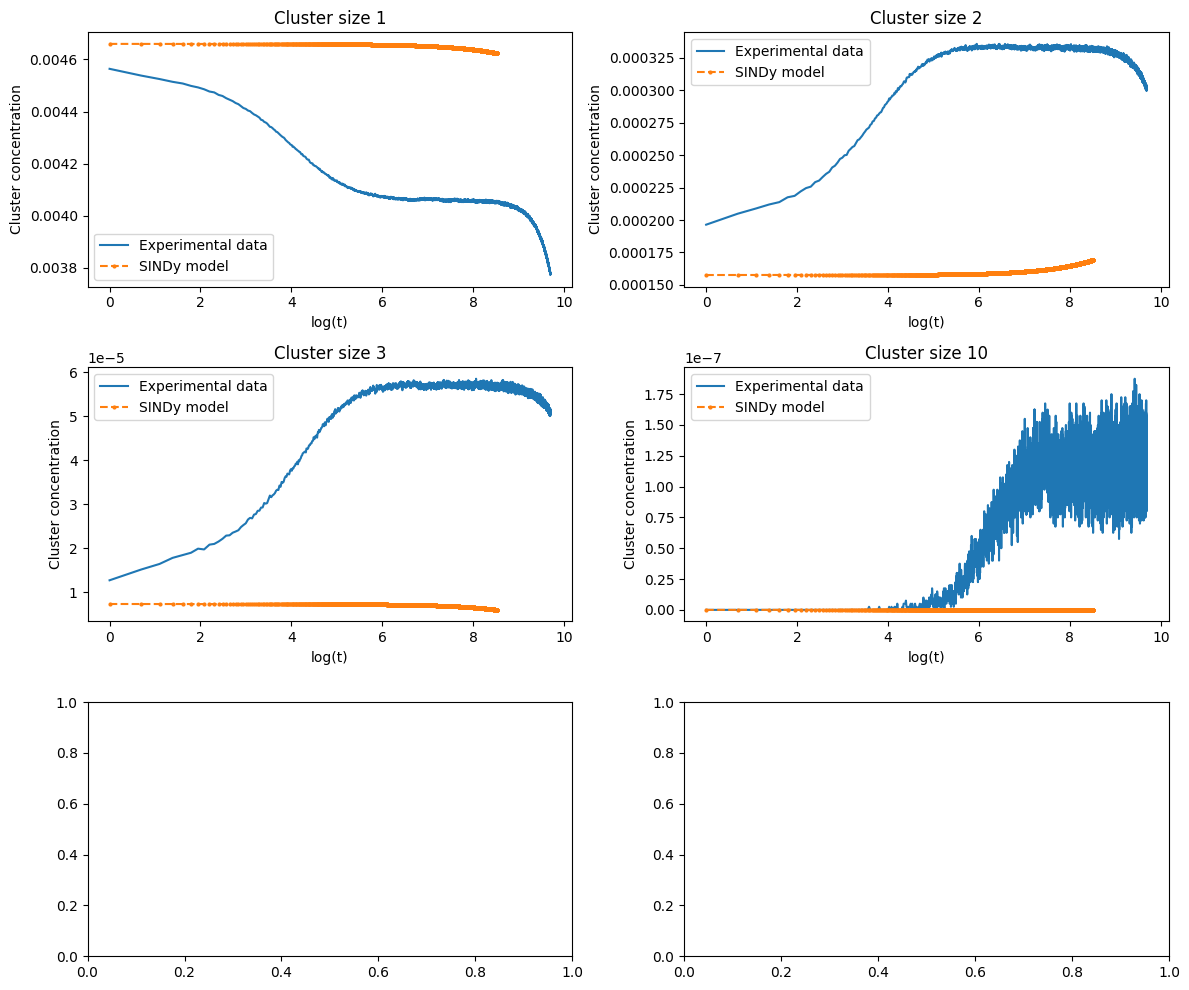

In [ ]:
# List of IDs to plot
ids_to_plot = [1, 2, 3, 10, 50, 100]

# Create subplot grid
fig, axs = plt.subplots(3, 2, figsize=(12, 10))

# Flatten the axs array for easier iteration
axs = axs.flatten()

# Log the time values
t_values_log = np.log(t_values)
t_sim_log = np.log(t_sim)

for i, n_to_plot in enumerate(ids_to_plot):
    
    if n_to_plot > system_size:
        print(f"Cluster size {n_to_plot} is larger than the system size {system_size}")
        continue
    # Plot the data
    axs[i].plot(t_values_log, N_clusters[:, n_to_plot-1], label=f'Experimental data')
    axs[i].plot(t_sim_log, n_sim[:, n_to_plot-1], label='SINDy model', marker='o', linestyle='dashed', markersize=2)
    axs[i].set_title(f'Cluster size {n_to_plot}')
    axs[i].legend()
    
    axs[i].set_xlabel('log(t)')
    axs[i].set_ylabel('Cluster concentration')

plt.tight_layout()
plt.show()